# Notebook to Investigate LSTM Performance Variance MSE v Hybrid Loss Function 

# Step 0 - Set up Notebook

In [6]:
# import needed libaries
import os
import boto3
import mlflow
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [8]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [30]:
def extract_step(df, step):
    df_filtered = df[df["Step"] == step].copy()
    return df_filtered

In [10]:
# function to extract only a specific metric if metric ends with name 
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [50]:
# Function to extract only a specific metric
def extract_metric_start(df, metric_name):
    """Extracts rows where the Metric column begins with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.startswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')


In [62]:
# set mlFlow tracking server 
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"

Skagit10 = "f0bde540d8184f7e8ea057456ec56f38" # new data 10 epochs, ML flow name is bittersweet-bug
Skagit12_16 = "215fe6997cc04f4493cce8d003dea9a5" # Skagit 12, batch size 16, epochs 10, nosy robin
Skagit12_64 = "d2f3f6f705014660917cfae0c0716236"  # Skagit 12 with 64 Batch size, MSEloss "nervous sponge"



In [48]:
def get_metric_dfs(run_id, epochs):
    metrics_all = load_ml_metrics(tracking_uri, run_id, save_local = True)
    metrics_step = extract_step(metrics_all, epochs-1)
    df_tkge = extract_metric_start(metrics_step, "test_kge")
    df_mse = extract_metric_start(metrics_step, "test_mse")
    return df_tkge, df_mse

In [51]:
Sk12_16mseloss_tkge, Sk12_16mseloss_tmse = get_metric_dfs(Skagit12_16, 10)
Sk12_16mseloss_tkge.head(2)

,Metric,Value
59,test_kge_171100050401,0.905121
99,test_kge_171100050402,0.870059


In [52]:
Sk12mseloss_tkge, Sk12_mseloss_tmse = get_metric_dfs(Skagit12_64, 10)
Sk12mseloss_tkge.head(2)

,Metric,Value
619,test_kge_171100050401,0.933558
679,test_kge_171100050402,0.953840


In [167]:
sk10 = load_ml_metrics(tracking_uri,Skagit10, save_local=False)
sk10_tkge = extract_metric(sk10, "test_kge")
sk10_tmse = extract_metric(sk10, "test_mse")
sk10_tkge.head(2)


,Metric,Value
2,1711000504_test_kge,0.938882
3,1711000505_test_kge,0.955074


# Step2 - Define Plotting Function To Compare Runs

In [163]:
def plot_side_by_side(*dfs_labels, title="Side-by-Side Metric Comparison", compare_line=None):
    """Plots a side-by-side bar chart comparing values from multiple DataFrames by Metric.
    
    Parameters:
        *dfs_labels: Variable-length arguments where each pair is (df, label).
                     Example usage: plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")
        title (str): Title of the plot.
        compare_line (tuple, optional): A tuple (median_value, label) to draw an additional axhline.
    """
    
    if len(dfs_labels) % 2 != 0:
        raise ValueError("Arguments must be given as (df1, label1, df2, label2, ...).")
    
    # Process input pairs
    dfs = dfs_labels[0::2]
    labels = dfs_labels[1::2]

    # Merge all DataFrames on 'Metric'
    merged_df = dfs[0][['Metric', 'Value']].rename(columns={'Value': f'Value_{labels[0]}'})
    for df, label in zip(dfs[1:], labels[1:]):
        merged_df = merged_df.merge(df[['Metric', 'Value']], on='Metric', how='inner', suffixes=('', f'_{label}'))
        merged_df = merged_df.rename(columns={'Value': f'Value_{label}'})  # Rename to avoid conflicts

    metrics = merged_df['Metric']
    values = [merged_df[f'Value_{label}'] for label in labels]
    medians = [np.median(val) for val in values]
    
    x = np.arange(len(metrics))  # Label locations
    width = 0.8 / len(labels)  # Adjust bar width dynamically based on the number of datasets
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for each dataset
    y_offset = 0  # Initialize offset

    for i, (val, label, median) in enumerate(zip(values, labels, medians)):
        bars = ax.bar(x + (i - len(labels)/2) * width, val, width, label=label, alpha=0.7)
        color = bars[0].get_facecolor()  # Get the color of the bars
        
        # Draw a median line for each dataset
        ax.axhline(y=median, color=color, linestyle='dashed', linewidth=2, alpha=0.8)
        if i > 0 and abs(median - medians[i-1]) < 0.05:  # Check if the medians are close
            y_offset = 0.05  # Adjust this value to control the distance
        ax.text(len(metrics) + 0.1, median, f"{label} Median: {median:.2f}", 
                va='center', ha='left', color=color, fontsize=10, fontweight='bold')
    
    # Draw the additional compare_line if provided
    if compare_line:
        compare_value, compare_label = compare_line
        ax.axhline(y=compare_value, color='black', linestyle='dashed', linewidth=4, alpha=0.8)
        ax.text(len(metrics) + 0.1, compare_value, f"{compare_label}: {compare_value:.2f}", 
                va='center', ha='left', color='black', fontsize=10, fontweight='bold')

    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    if not compare_line:
        ax.legend()

    plt.show()



# Step 3 Compare Results Batch Size 

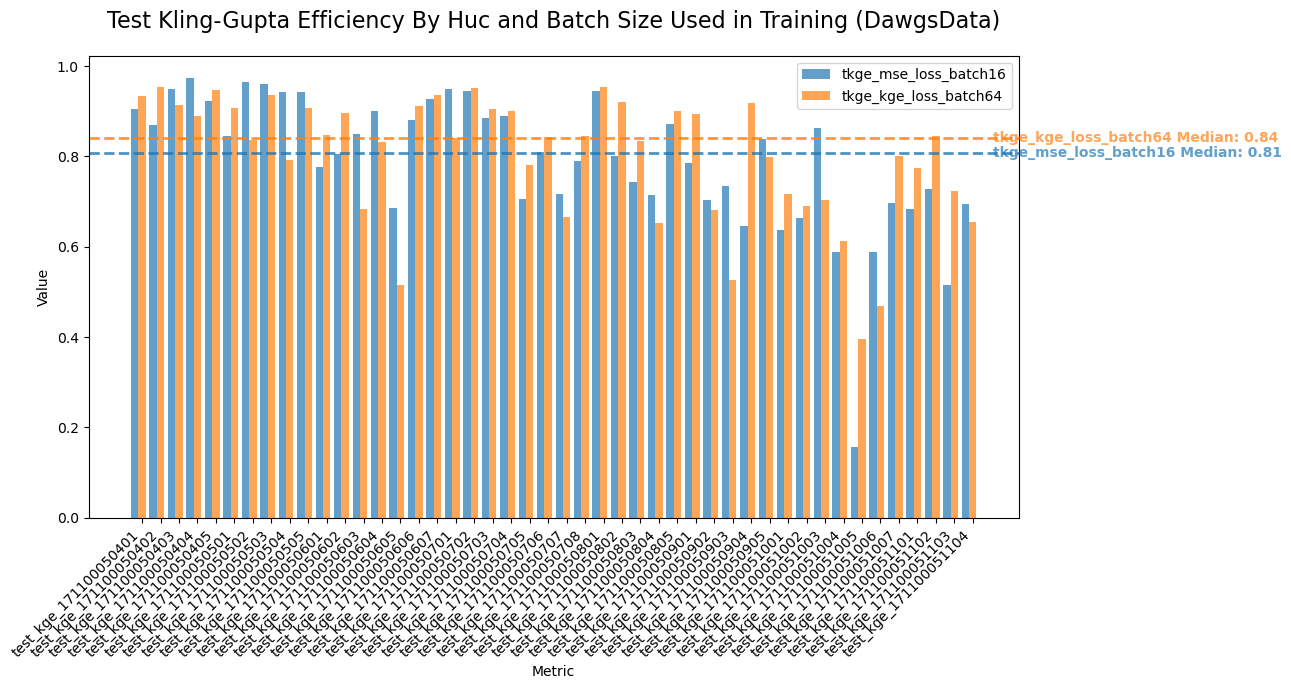

In [164]:
# Test Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(Sk12_16mseloss_tkge, "tkge_mse_loss_batch16", 
                  Sk12mseloss_tkge, "tkge_kge_loss_batch64", 
                  title = "Test Kling-Gupta Efficiency By Huc and Batch Size Used in Training (DawgsData)")

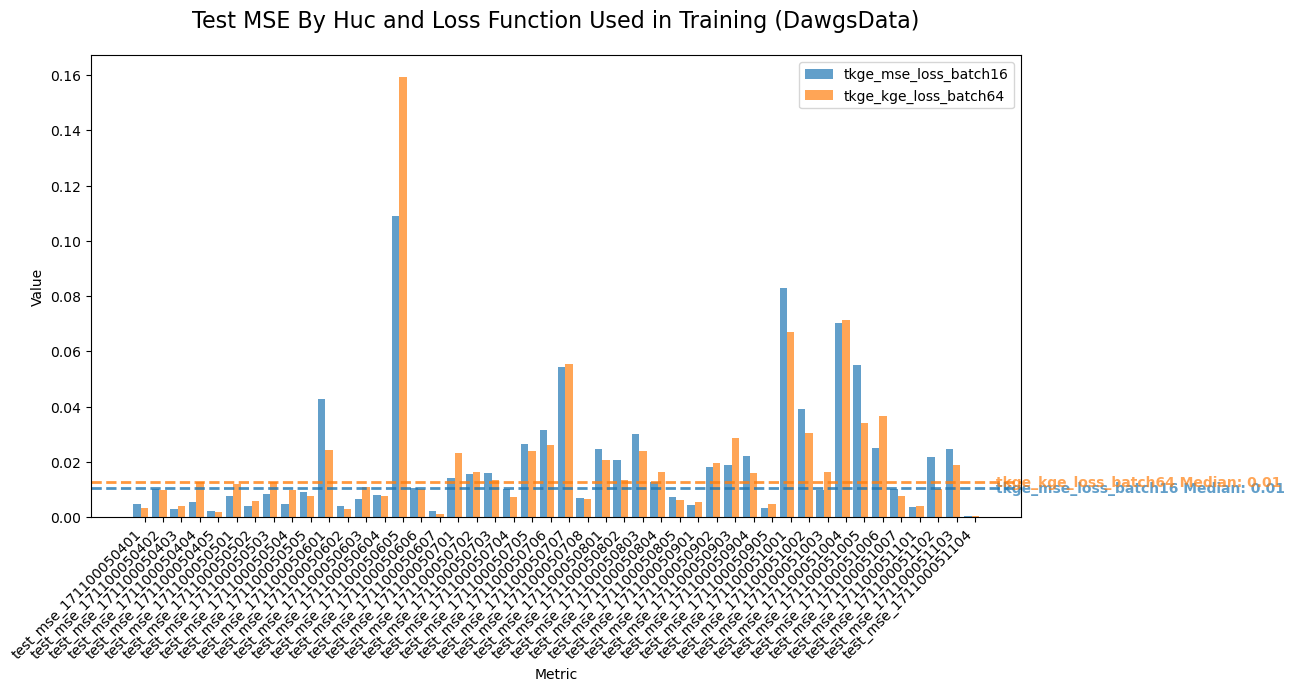

In [165]:
# Test MSE (Lower is better; 1 is Perfect) 
plot_side_by_side(Sk12_16mseloss_tmse, "tkge_mse_loss_batch16", 
                  Sk12_mseloss_tmse, "tkge_kge_loss_batch64",
                  title = "Test MSE By Huc and Loss Function Used in Training (DawgsData)")

# Step 4 Functions to Plot results by Huc10 Region

In [97]:


def group_metrics_by_huc10(df, prefix):
    """
    Groups metrics in the given DataFrame by the first 10 digits of the 12-digit HUC number.

    Assumes the Metric format is '{prefix}171100050401', where the last 12 digits are the HUC number.

    Parameters:
        df (pd.DataFrame): A DataFrame with columns ['Metric', 'Value'].
        prefix (str): The leading string before the HUC number (e.g., 'test_kge_' or 'test_mse_').

    Returns:
        dict: A dictionary where keys are 10-digit HUC numbers and values are DataFrames
              containing metrics that belong to the same 10-digit HUC.
    """
    # Construct the regex dynamically based on the given prefix
    pattern = rf'{prefix}(\d{{10}})'

    # Extract the first 10 digits of the 12-digit HUC number
    df['HUC10'] = df['Metric'].str.extract(pattern)

    # Group by the extracted HUC10 and create a dictionary of DataFrames
    huc_dict = {huc: group.drop(columns=['HUC10']) for huc, group in df.groupby('HUC10')}
    
    return huc_dict

In [98]:
sk12_dict = group_metrics_by_huc10(Sk12mseloss_tkge, "test_kge_")
# display an example
sk12_dict['1711000504'].head(2)

,Metric,Value
619,test_kge_171100050401,0.933558
679,test_kge_171100050402,0.953840


In [151]:
def plot_gran_compare_kge(huc_num): 
    df_1 = sk12_dict[huc_num]
    label_1 = f"tkge_huc_{huc_num}_subunits"
    df_2 = sk10_tkge.loc[sk10_tkge["Metric"] == f"{huc_num}_test_kge"]
    compare_val = df_2.iloc[0]["Value"]
    compare_label = f"tkge_huc_{huc_num}_single_model"
    ttle = f"Test KGE for Individually Modelled Huc12 units in {huc_num}"
    plot_side_by_side(df_1, label_1, title = ttle, compare_line = (compare_val, compare_label))

# Step 5A Test KGE Plots 

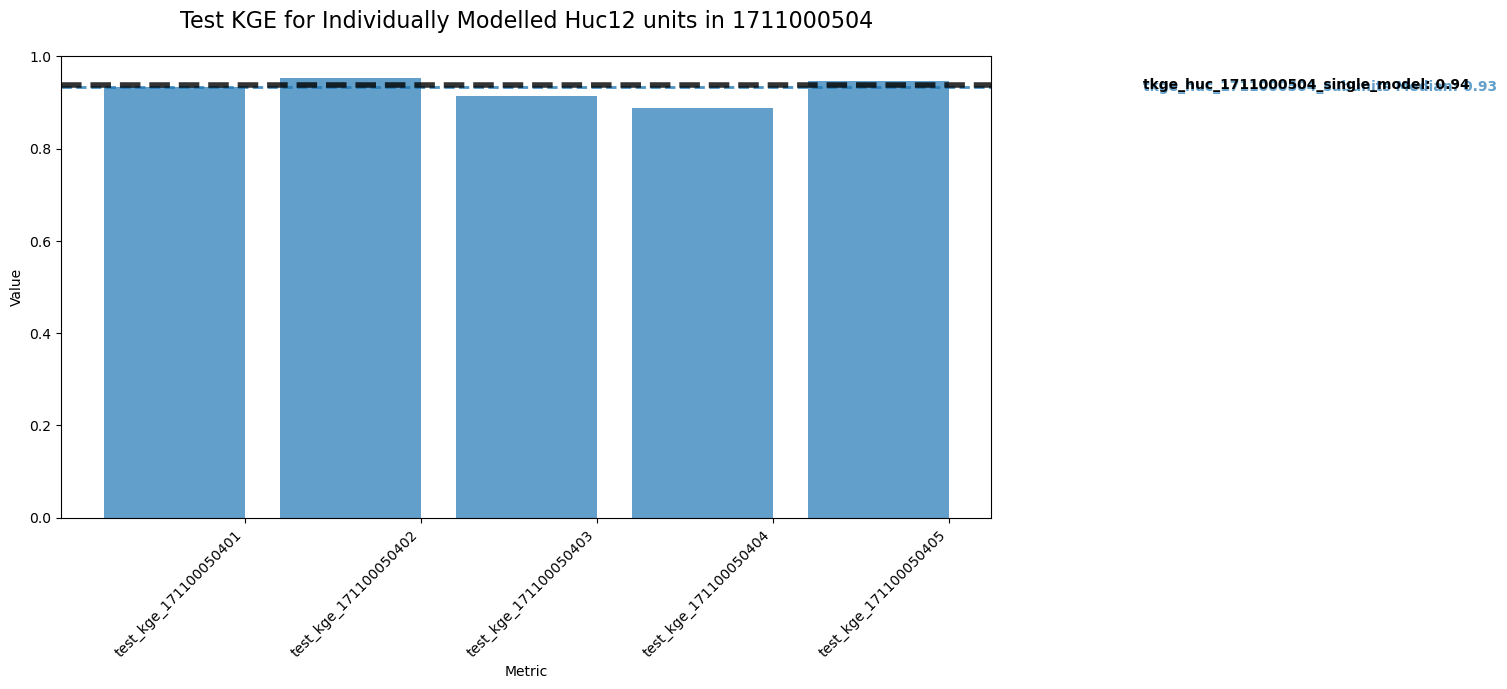

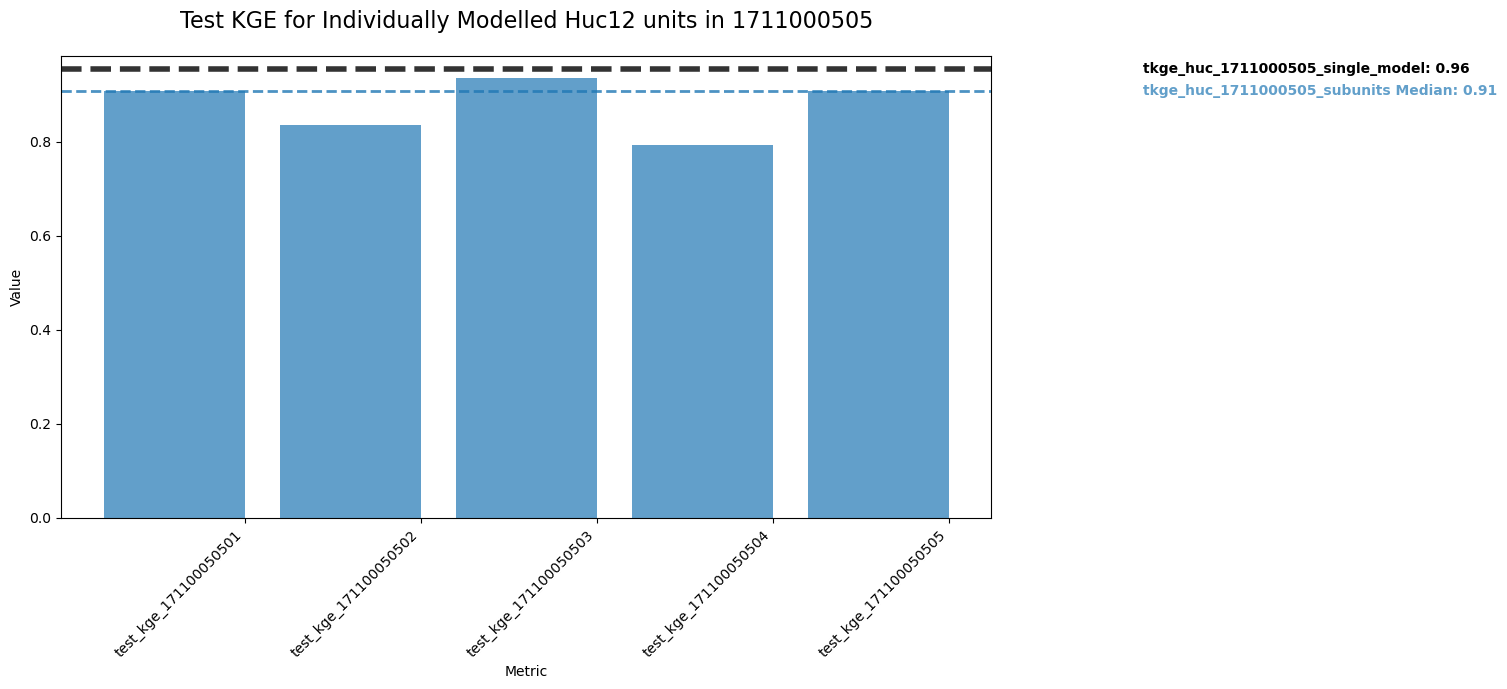

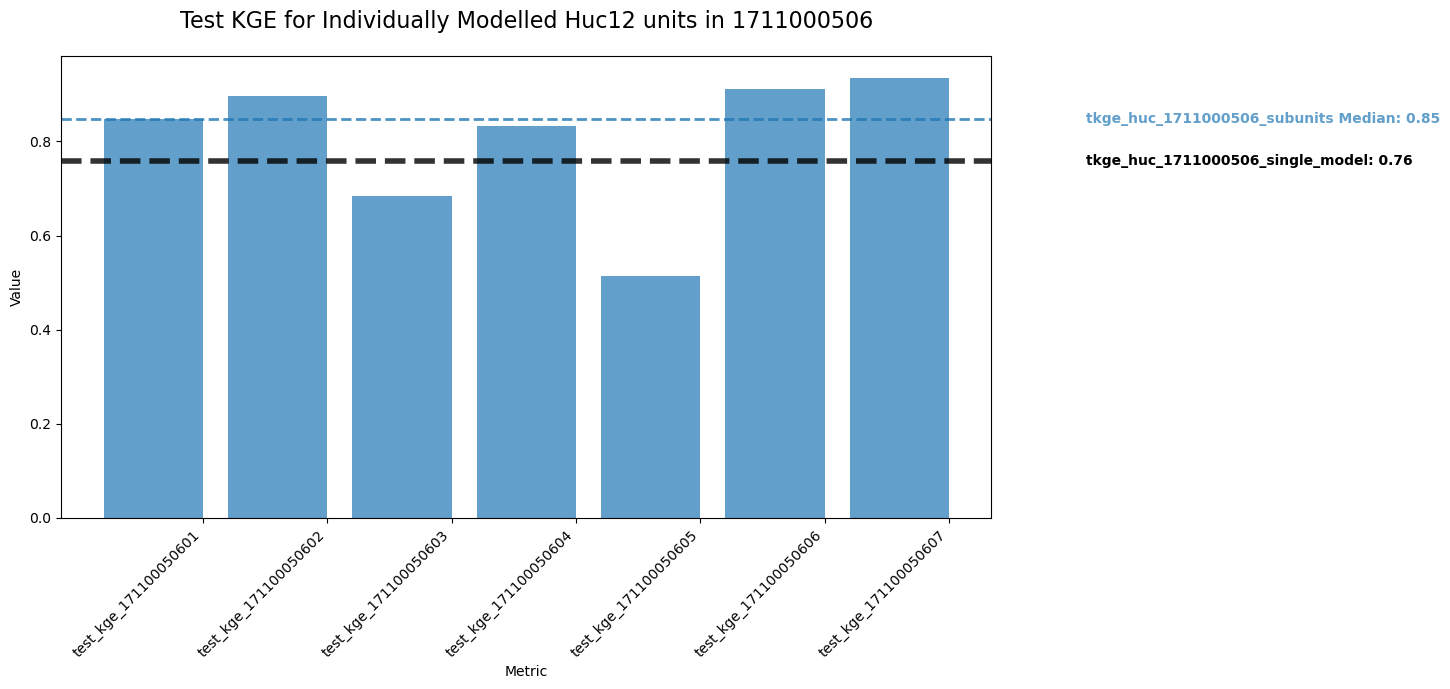

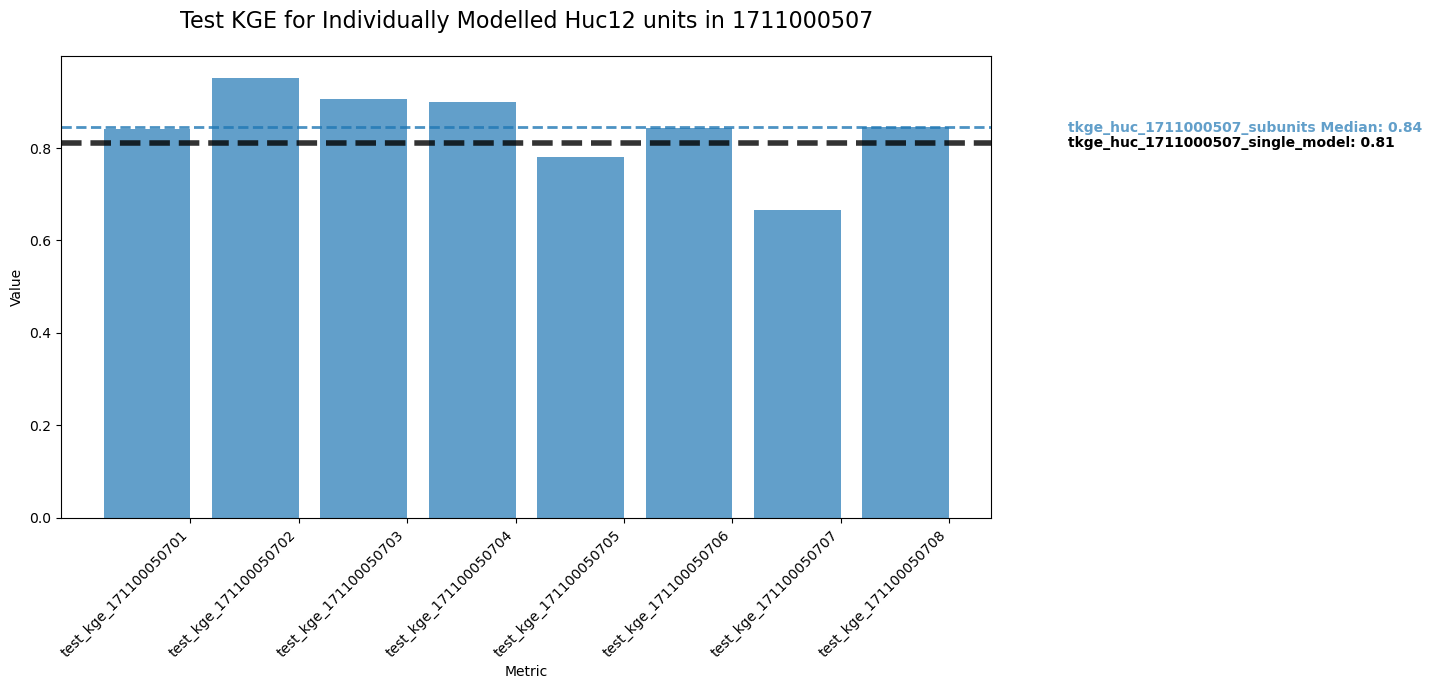

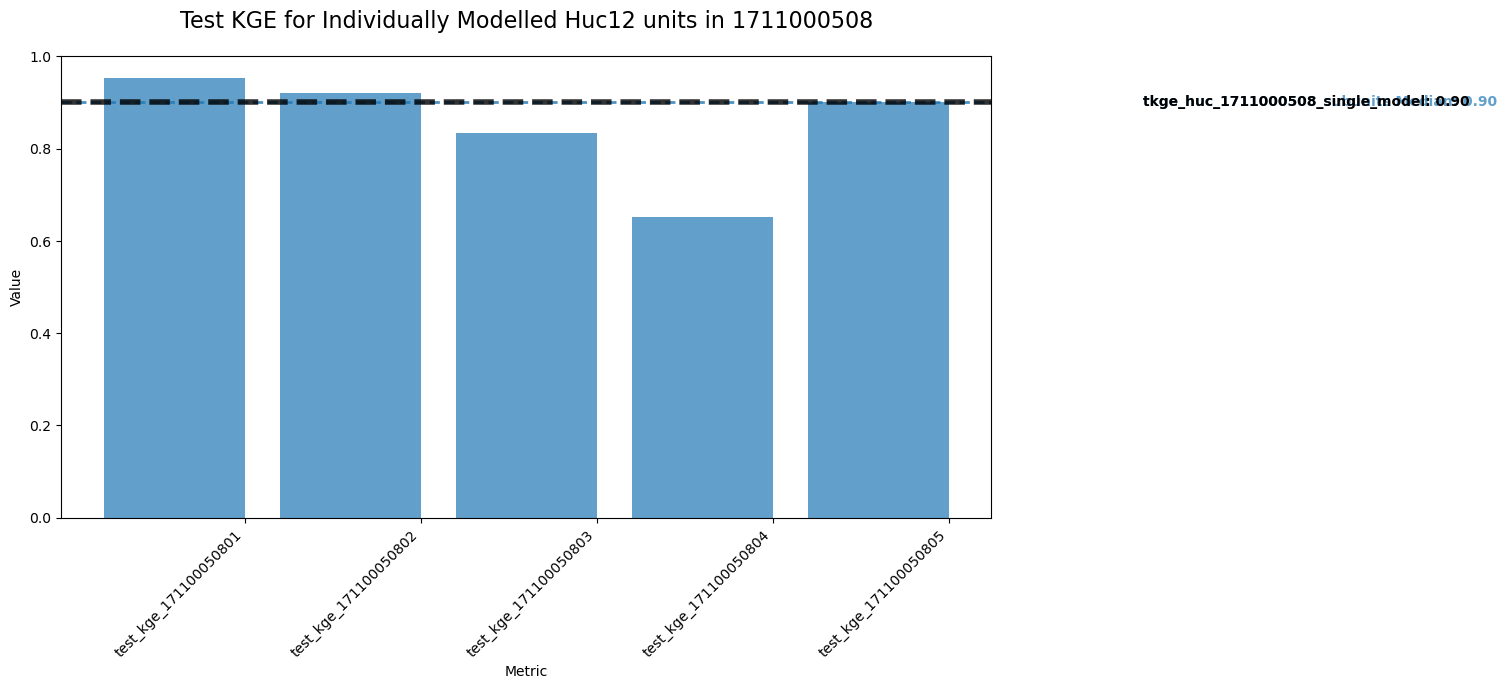

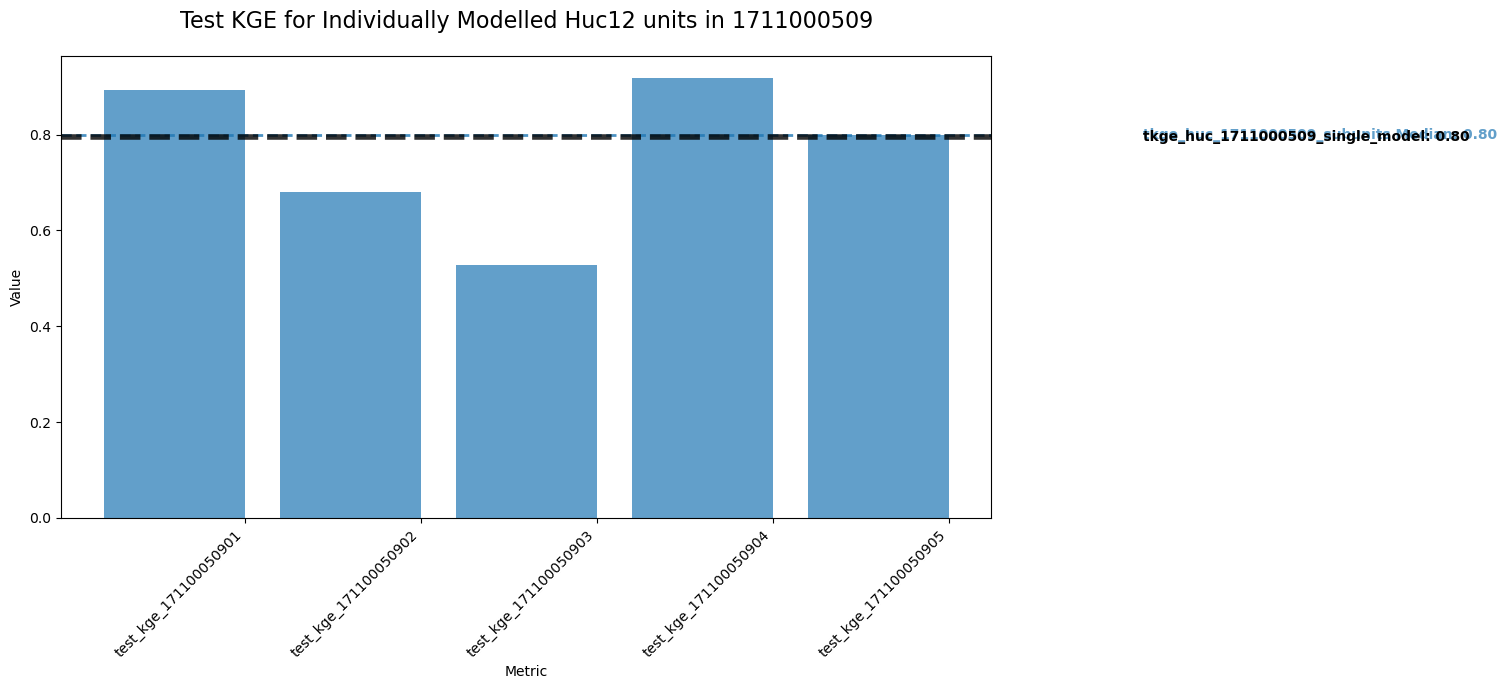

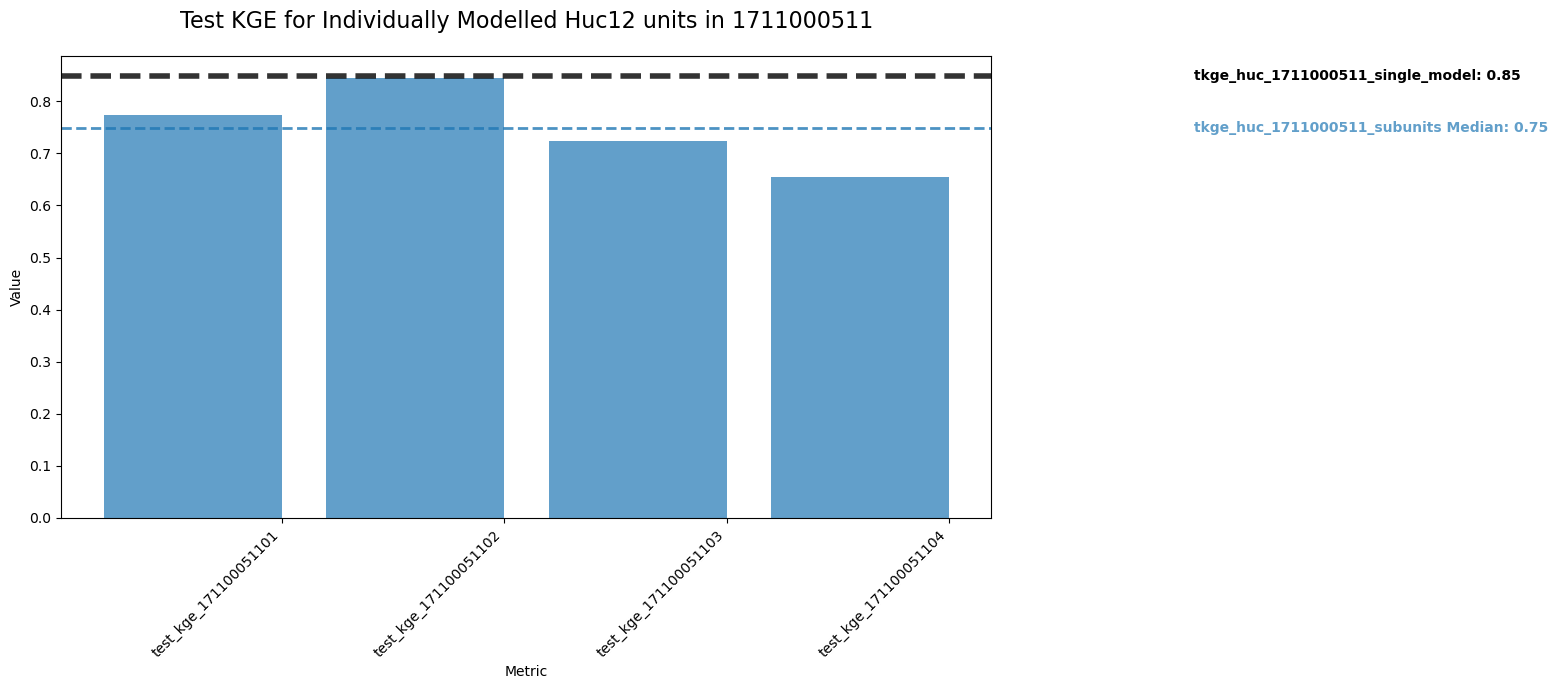

In [153]:
huc_list = ["1711000504", "1711000505", "1711000506", "1711000507", "1711000508", "1711000509", "1711000511"]
for huc_num in huc_list:
    plot_gran_compare_kge(huc_num)

# Step 5B Test MSE Plots 

In [160]:
sk12_mse_dict = group_metrics_by_huc10(Sk12_mseloss_tmse, "test_mse_")
# display an example
sk12_mse_dict['1711000504'].head(2)

,Metric,Value
599,test_mse_171100050401,0.003177
659,test_mse_171100050402,0.009802


In [169]:
def plot_gran_compare_mse(huc_num): 
    df_1 = sk12_mse_dict[huc_num]
    label_1 = f"tmse_huc_{huc_num}_subunits"
    df_2 = sk10_tmse.loc[sk10_tmse["Metric"] == f"{huc_num}_test_mse"]
    compare_val = df_2.iloc[0]["Value"]
    compare_label = f"tmse_huc_{huc_num}_single_model"
    ttle = f"Test MSE for Individually Modelled Huc12 units in {huc_num}"
    plot_side_by_side(df_1, label_1, title = ttle, compare_line = (compare_val, compare_label))

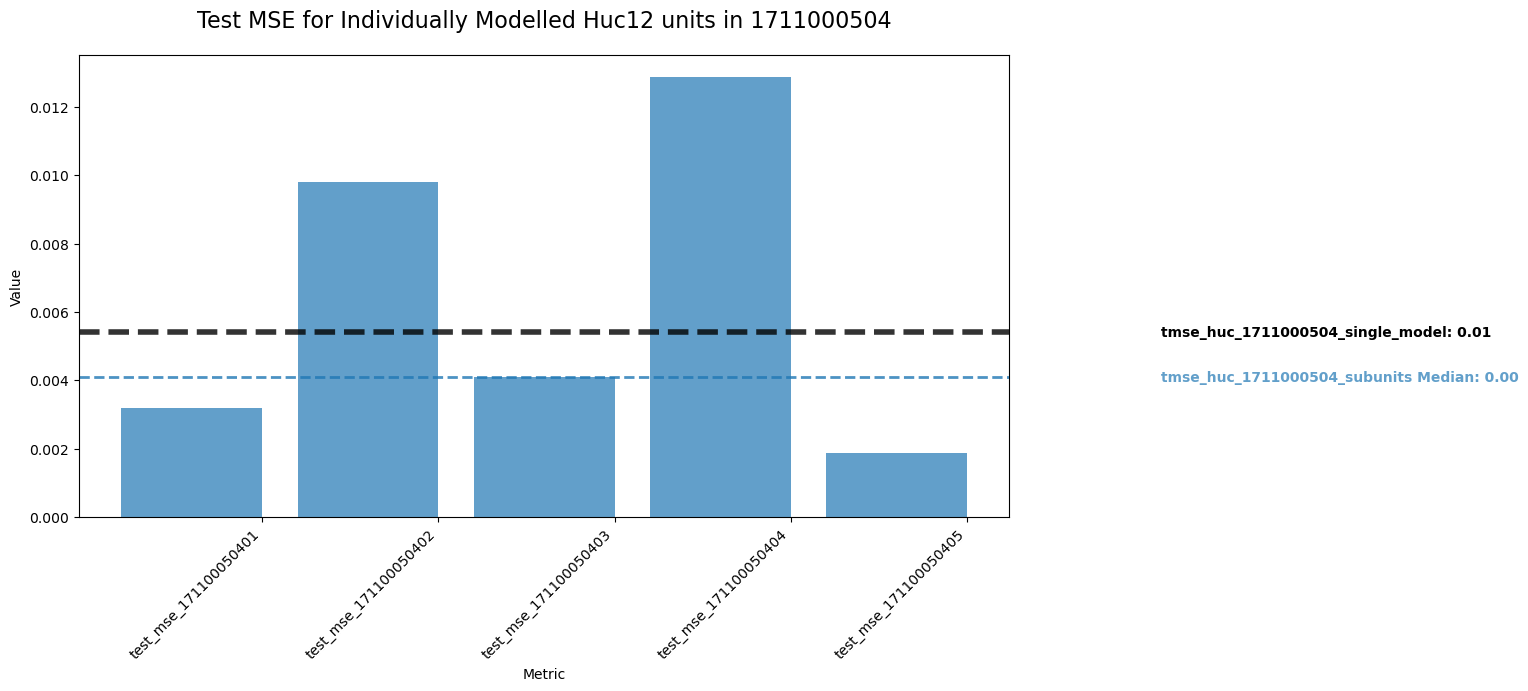

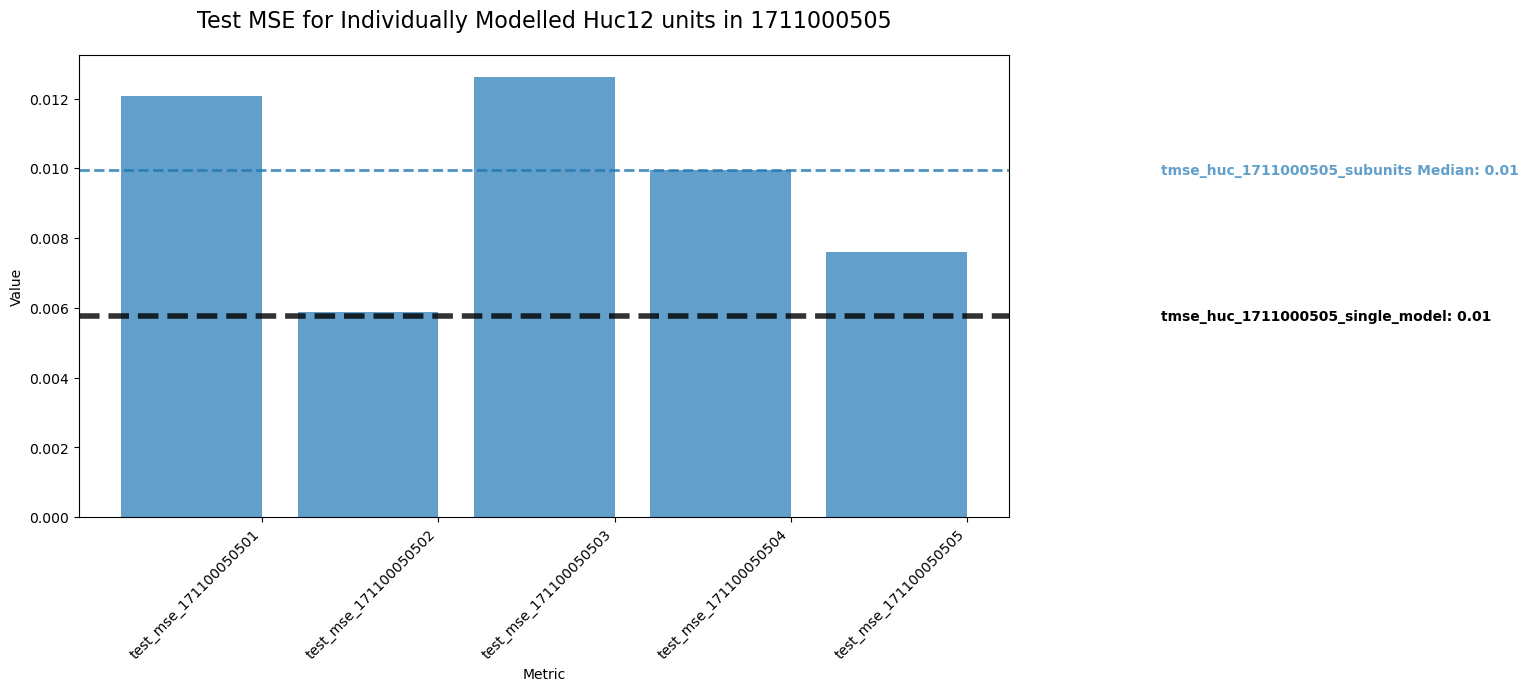

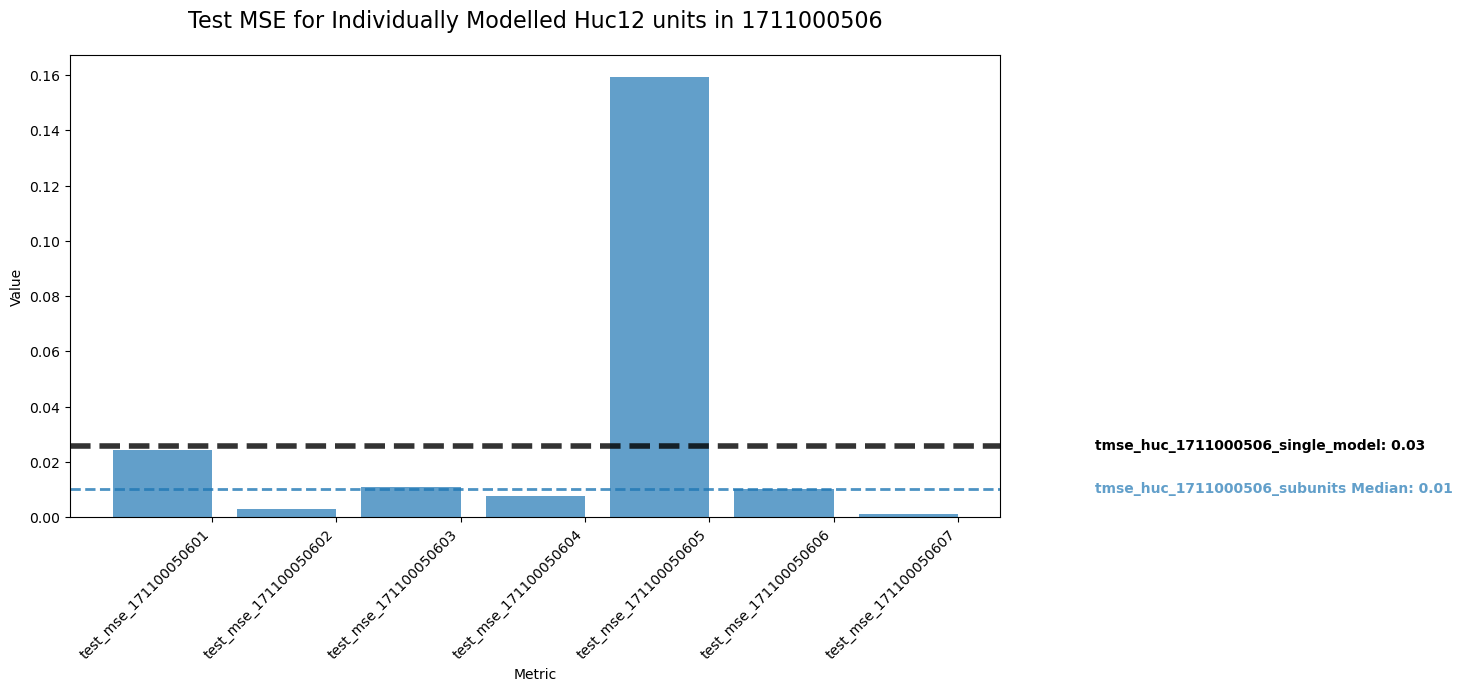

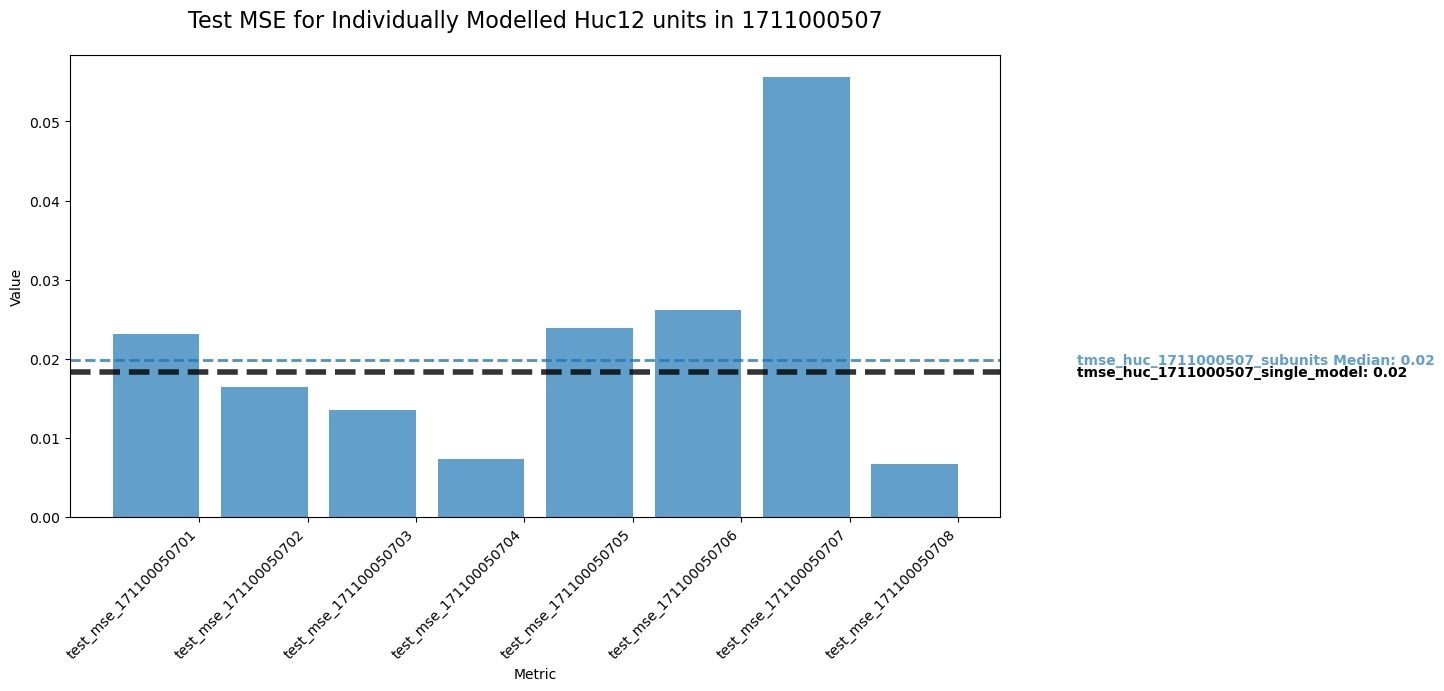

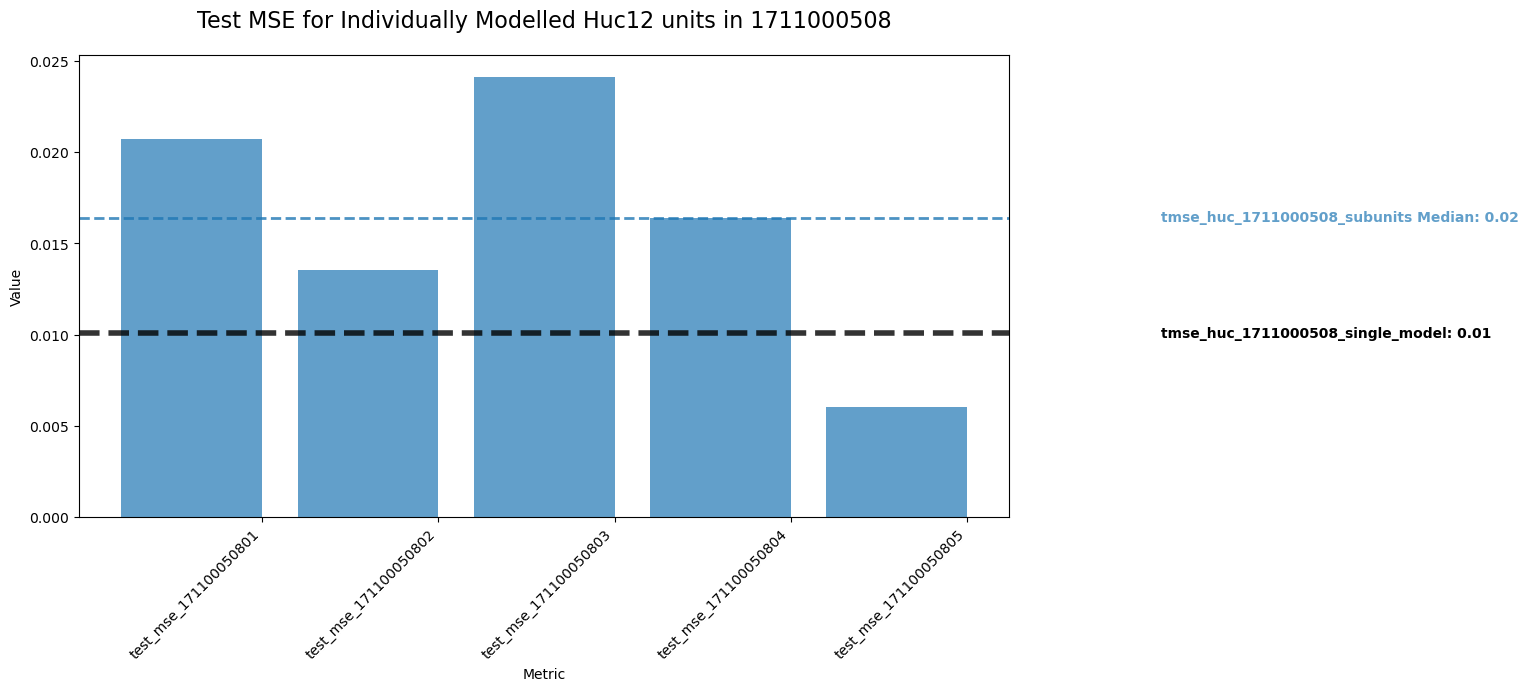

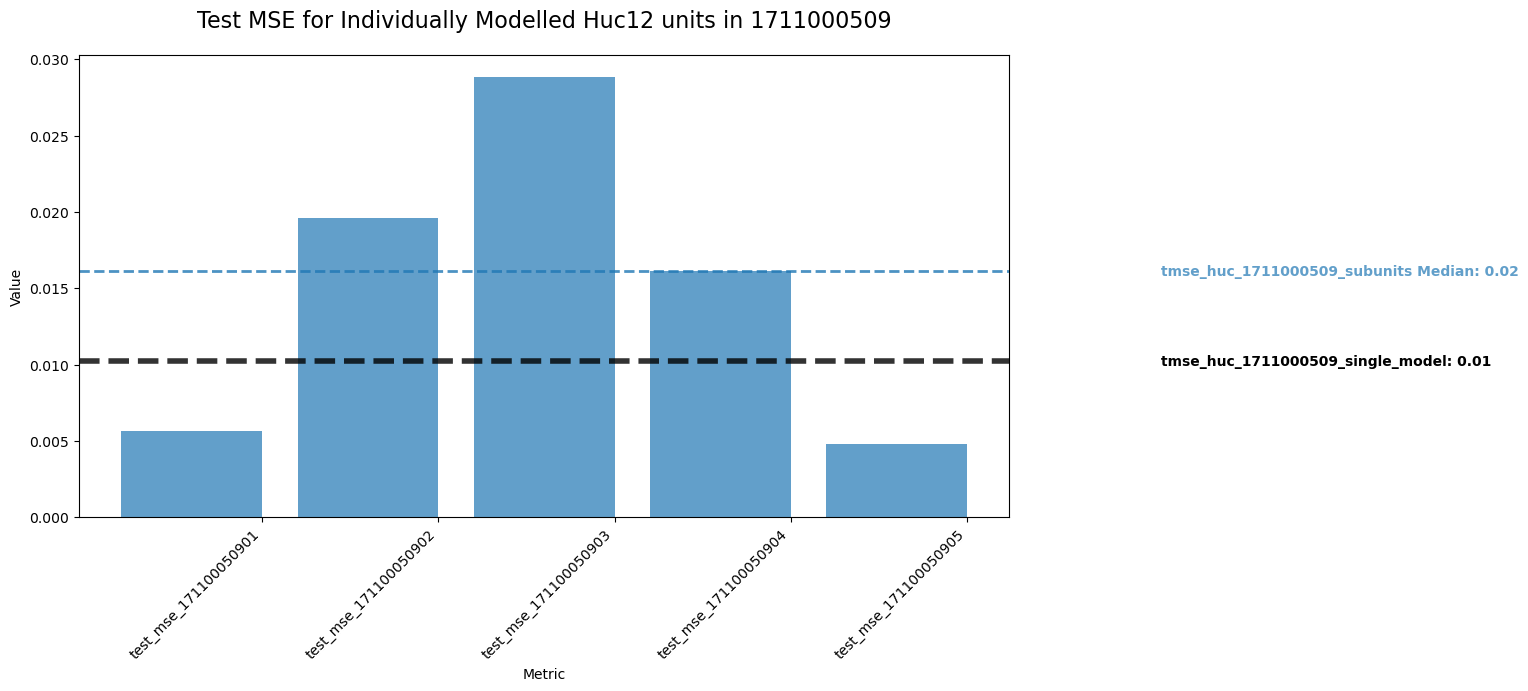

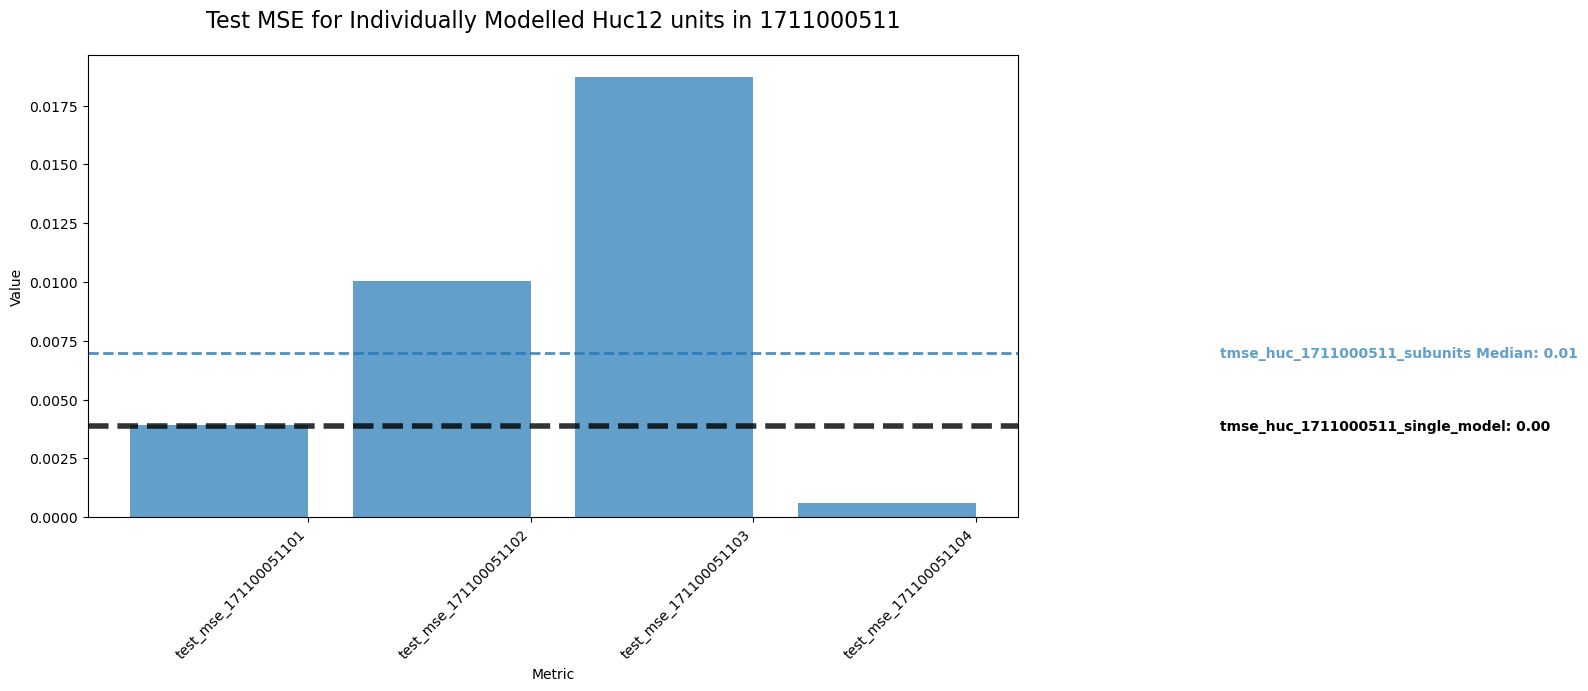

In [171]:
huc_list = ["1711000504", "1711000505", "1711000506", "1711000507", "1711000508", "1711000509", "1711000511"]
for huc_num in huc_list:
    plot_gran_compare_mse(huc_num)